## Using NFNull

In [11]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nfnull import NFNull

def gmm_xdf(x, locs, scales, ws, sf=False):
    """ 
    Gaussian mixture model
    """
    pdfs = np.zeros(len(x))
    cdfs = np.zeros(len(x))
    for i in range(len(locs)):
        pdfs += ws[i] * scipy.stats.norm.pdf(x, loc=locs[i], scale=scales[i])
        if sf:
            cdfs += ws[i] * scipy.stats.norm.sf(x, loc=locs[i], scale=scales[i])
        else:
            cdfs += ws[i] * scipy.stats.norm.cdf(x, loc=locs[i], scale=scales[i])        
    return pdfs, cdfs

def expuu_xdf(x, ws, rate=3, a0=0, b0=10, a1=9, b1=10, sf=False):
    """ 
    Exponential / Uniform mixture model
    """
    pdfs = np.zeros(len(x))
    cdfs = np.zeros(len(x))
    pdfs = ws[0] * scipy.stats.expon.pdf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.pdf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.pdf(x, loc=a1, scale=b1)
    if sf:
     cdfs = ws[0] * scipy.stats.expon.sf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.sf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.sf(x, loc=a1, scale=b1)    
    else:
     cdfs = ws[0] * scipy.stats.expon.cdf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.cdf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.cdf(x, loc=a1, scale=b1)
    return pdfs, cdfs


def symm_diff(x, y):
    if (x > 0.5) and (y > 0.5):
        return (1-x) / (1-y)
    else:
        return x/y

def ecdf(x):
    x = np.sort(x)
    n = len(x)
    def _ecdf(v):
        # side='right' because we want Pr(x <= v)
        return (np.searchsorted(x, v, side='right') + 1) / n
    return _ecdf

### Map the normal distribution to itself

In [30]:
x = scipy.stats.norm.rvs(size=500)
nfn = NFNull(x)
nfn.fit_pdf(verbose=True, patience=5)

print(f"Analytic p-value: {scipy.stats.norm.sf(4.9)}")
print(f"Empirical mean from samples {np.mean(x > 4.9)}")
print(f"Neural approx: {nfn.p_value(4.9)}")

Epoch 0: mean loss = 11.778709411621094, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 3.3312792778015137, best = 11.778709411621094
Patience counter: 0/5
Epoch 2: mean loss = 1.7590997219085693, best = 3.3312792778015137
Patience counter: 0/5
Epoch 3: mean loss = 1.8551645278930664, best = 1.7590997219085693
Patience counter: 0/5
Epoch 4: mean loss = 1.8594632148742676, best = 1.7590997219085693
Patience counter: 1/5
Epoch 5: mean loss = 1.7303059101104736, best = 1.7590997219085693
Patience counter: 2/5
Epoch 6: mean loss = 1.6568690538406372, best = 1.7303059101104736
Patience counter: 0/5
Epoch 7: mean loss = 1.6127793788909912, best = 1.6568690538406372
Patience counter: 0/5
Epoch 8: mean loss = 1.583890438079834, best = 1.6127793788909912
Patience counter: 0/5
Epoch 9: mean loss = 1.5585993528366089, best = 1.583890438079834
Patience counter: 0/5
Epoch 10: mean loss = 1.5484340190887451, best = 1.5585993528366089
Patience counter: 0/5
Epoch 11: mean loss = 1.5216095447540

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/411524426.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/2310598153.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

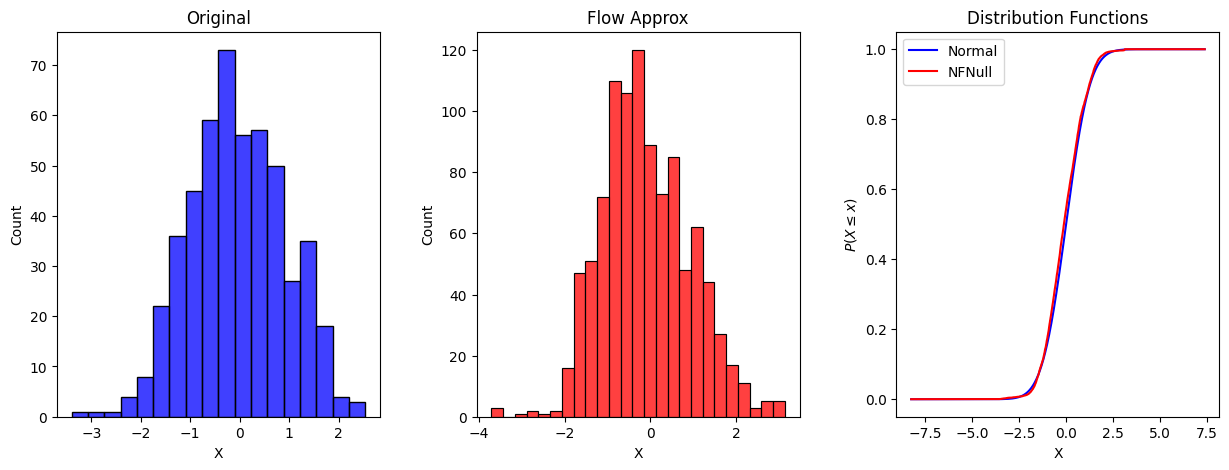

In [31]:
nfcdf = nfn.get_cdf()
x_cdf = scipy.stats.norm.cdf(nfn.grid)
plt.subplots_adjust(wspace=0.3)
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Normal CDF': x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)]))
                       })

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
x_hat = nfn.sample(n=1000)

sns.histplot(x=x, ax=ax[0], color='b').set(title='Original')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r').set(title='Flow Approx')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Normal CDF', ax=ax[2], color='blue', label='Normal').set(title='Distribution Functions')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='NFNull')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()

### Trimodal distribution

Here the target is $x \sim 0.3\cdot N(-1, 0.25) + 0.3\cdot N(0, 0.25) + 0.4\cdot N(1.5, 0.2)$


In [36]:
## generate trimodal distribution
x = np.concatenate((
    scipy.stats.norm.rvs(loc=-1, scale=0.25, size=150),
    scipy.stats.norm.rvs(loc=0, scale=0.25, size=150),
    scipy.stats.norm.rvs(loc=1.5, scale=0.25, size=200)
))
nfn = NFNull(x, prescaled=False)
nfn.fit_pdf(verbose=True, patience=5)

print(f"Analytic p-value: {gmm_xdf([4.9], [-1, 0, 1.5], [0.25]*3, [0.3, 0.3, 0.4], sf=True)[1][0]}")
print(f"Empirical mean from samples {np.mean(x > 4.9)}")
print(f"Neural approx: {nfn.p_value(4.9)}")

Epoch 0: mean loss = 10.655787467956543, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 6.812228202819824, best = 10.655787467956543
Patience counter: 0/5
Epoch 2: mean loss = 3.760681629180908, best = 6.812228202819824
Patience counter: 0/5
Epoch 3: mean loss = 2.178079128265381, best = 3.760681629180908
Patience counter: 0/5
Epoch 4: mean loss = 2.440549850463867, best = 2.178079128265381
Patience counter: 0/5
Epoch 5: mean loss = 2.236063003540039, best = 2.178079128265381
Patience counter: 1/5
Epoch 6: mean loss = 1.963059425354004, best = 2.178079128265381
Patience counter: 2/5
Epoch 7: mean loss = 1.8604001998901367, best = 1.963059425354004
Patience counter: 0/5
Epoch 8: mean loss = 1.7418553829193115, best = 1.8604001998901367
Patience counter: 0/5
Epoch 9: mean loss = 1.6356068849563599, best = 1.7418553829193115
Patience counter: 0/5
Epoch 10: mean loss = 1.5349761247634888, best = 1.6356068849563599
Patience counter: 0/5
Epoch 11: mean loss = 1.4304418563842773, best 

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/411524426.py:46: RuntimeWarning: invalid value encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/480407704.py:9: RuntimeWarning: divide by zero encountered in log10
  'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/480407704.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


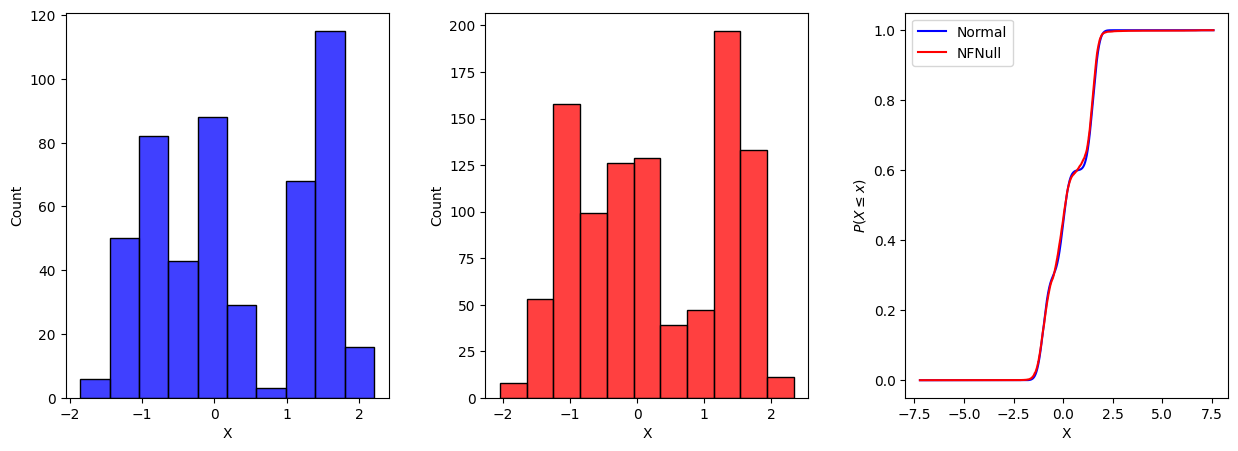

In [37]:
x_pdf, x_cdf = gmm_xdf(nfn.grid, [-1, 0, 1.5], [0.25]*3, [0.3, 0.3, 0.4])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
nfcdf = nfn.get_cdf()
plt.subplots_adjust(wspace=0.3)
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Analytic CDF': x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
                       })

x_hat = nfn.sample(n=1000)
sns.histplot(x=x, ax=ax[0], color='b')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Analytic CDF', ax=ax[2], color='blue', label='Normal')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='NFNull')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()


### Exponential / Uniform Mixture

Here the target is $x \sim 0.86\cdot Exp(3) + 0.1\cdot U(0, 10) + 0.04\cdot U(9,10)$.

The 2 uniforms both add skewness and the 2nd uniform adds a small mode far from the main one.

In [46]:
x = torch.cat((
    torch.distributions.exponential.Exponential(rate=1.5).sample(torch.Size(torch.tensor([430]))), 
    torch.distributions.uniform.Uniform(low=0, high=11).sample(torch.Size(torch.tensor([50]))), 
    torch.distributions.uniform.Uniform(low=9, high=10).sample(torch.Size(torch.tensor([20]))),     
)).cpu().numpy()
nfn = NFNull(x, prescaled=False, min_support=0)
nfn.fit_pdf(verbose=True, patience=5)

cts = [430, 50, 20]
w = np.array(cts)/np.sum(cts)
q = 9.6
x_hat = nfn.sample(n=1000)
x_pdf, x_cdf = expuu_xdf(nfn.grid, w, sf=True)
nfcdf = nfn.get_cdf()

print(f"Analytic p-valu: {expuu_xdf([q], w, sf=True)[1][0]}")
print(f"Empirical mean from samples {np.mean(x > q)}")
print(f"Neural approx: {nfn.p_value(q, greater_than=True)}")

Epoch 0: mean loss = 19.216426849365234, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 2.354034423828125, best = 19.216426849365234
Patience counter: 0/5
Epoch 2: mean loss = 2.676443099975586, best = 2.354034423828125
Patience counter: 0/5
Epoch 3: mean loss = 0.9663302898406982, best = 2.354034423828125
Patience counter: 1/5
Epoch 4: mean loss = 0.9538530111312866, best = 0.9663302898406982
Patience counter: 0/5
Epoch 5: mean loss = 0.7315566539764404, best = 0.9538530111312866
Patience counter: 0/5
Epoch 6: mean loss = 0.5883811116218567, best = 0.7315566539764404
Patience counter: 0/5
Epoch 7: mean loss = 0.5465841293334961, best = 0.5883811116218567
Patience counter: 0/5
Epoch 8: mean loss = 0.5209344625473022, best = 0.5465841293334961
Patience counter: 0/5
Epoch 9: mean loss = 0.4917093515396118, best = 0.5209344625473022
Patience counter: 0/5
Epoch 10: mean loss = 0.46465378999710083, best = 0.4917093515396118
Patience counter: 0/5
Epoch 11: mean loss = 0.44710737466812

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/2946776831.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


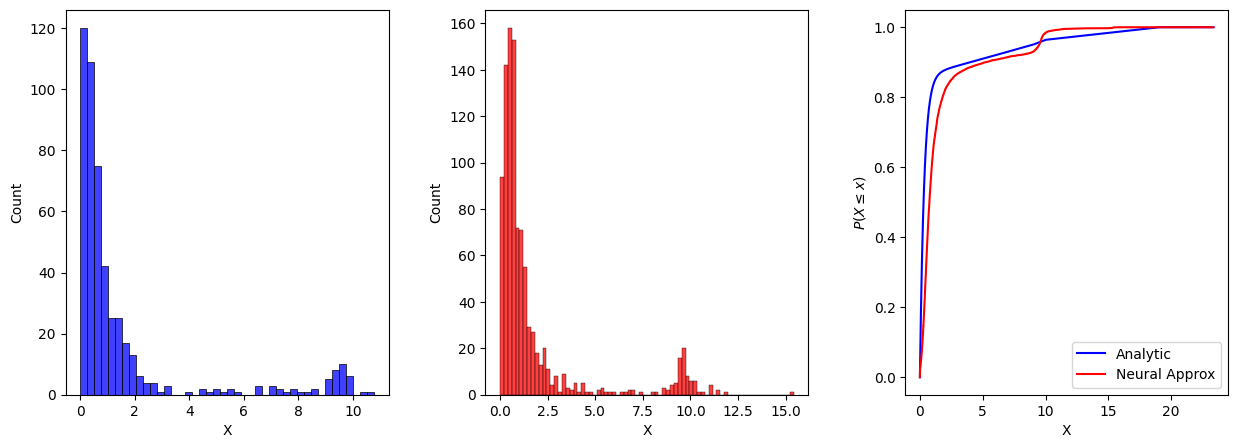

In [47]:
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Analytic CDF': 1-x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
                       })

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
sns.histplot(x=x, ax=ax[0], color='b')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Analytic CDF', ax=ax[2], color='blue', label='Analytic')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='Neural Approx')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()